## DCGAN - Part1

In [1]:
# Numpy and matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Keras
import keras.datasets as ds
from keras.optimizers import Adam
from keras.models import load_model
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, BatchNormalization, UpSampling2D
from keras.layers import Input, Embedding, Concatenate

# Support tools
from IPython.display import Image
import imageio
import time
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


In [ ]:
# Load selected dataset and make some preprocessing
def load_dataset(dataset):

    if dataset == 'MNIST-D':
        (trainX, trainy), (_, _) = ds.mnist.load_data()

    if dataset == 'MNIST-F':
        (trainX, trainy), (_, _) = ds.fashion_mnist.load_data()

    # Exapnd to 3D adding one channel
    X = np.expand_dims(trainX, axis=-1)

    # Convert from int to float and rescale from [0, 255] to [-1, 1]
    X = X.astype('float32')
    X = (X - (255 / 2)) / (255 / 2)
    #X = X / 255.
    return [X, trainy]

In [2]:
# Build Discriminator
def build_discriminator(input_shape):

    # Initialize the NN
    model = Sequential()

    # First convolutional layer
    model.add(Conv2D(128, 3, strides=2, padding='same', input_shape=input_shape))
    model.add(BatchNormalization(momentum=0.9))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))

    # Second convolutional layer
    model.add(Conv2D(256, 3, strides=2, padding='same'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))

    # Flattening and output layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model



# Build Generator with default latent_space=100
def build_generator(latent_dim=100):

    # Initialize the NN
    model = Sequential()

    # Fully connected layer
    model.add(Dense(7 * 7 * 256, input_dim=latent_dim))
    model.add(BatchNormalization(momentum=0.9))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 256)))
    model.add(Dropout(0.4))

    # First upsampling layer 14x14
    model.add(UpSampling2D())
    model.add(Conv2D(256, 3, padding='same'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(LeakyReLU(alpha=0.2))
    
    # Second upsampling layer 28x28
    model.add(UpSampling2D())
    model.add(Conv2D(128, 3, padding='same'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(LeakyReLU(alpha=0.2))
    
    # Output layer
    model.add(Conv2D(1, 3, activation='tanh', padding='same'))
    return model



# Build the GAN framework
def build_gan(D, G):

    opt = Adam(lr=0.0002, beta_1=0.5)

    # Freeze discriminator weights during generator training
    D.trainable = False

    # Connect generator and discriminator
    GAN = Sequential()
    GAN.add(G)
    GAN.add(D)
    GAN.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return GAN

In [3]:
# Extract random samples from the training dataset
def gen_real(dataset, batch_size):
    X = dataset[np.random.randint(0, dataset.shape[0], size=batch_size), :, :, :]
    y = np.ones((batch_size, 1))
    return X, y


# Generate batch_size samples from the generator
def gen_fake(G, latent_dim, batch_size):
    z = np.random.randn(latent_dim * batch_size)
    z = z.reshape(batch_size, latent_dim)
    X = G.predict(z)
    y = np.zeros((batch_size, 1))
    return X, y


# Save generator predictions
def save_plot(G, noise, epoch, name):
    # Plot generator prediction on sample_noise
    images = G.predict(noise)
    plt.figure(figsize=(10,10))
        
    for im in range(images.shape[0]):
        plt.subplot(4, 4, im+1)
        image = images[im, :, :, :]
        image = np.reshape(image, [28, 28])
            
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        
    plt.tight_layout()
    plt.savefig(f'Output/{name}/{epoch}.png')
    plt.close('all')
    

# Save generator and discriminator models
def save_model(epoch, G, D, name):
    
    # save the generator model tile file
    filename = f'Model/{name}/Generator/G_{epoch + 1}.h5'
    G.save(filename)
    
    # save the generator model tile file
    filename = f'Model/{name}/Discriminator/D_{epoch + 1}.h5'
    G.save(filename)


# Train the GAN
def train(D, G, GAN, dataset, name, latent_dim=100, epochs=20, batch_size=128):
    
    batch_per_epoch = int(dataset.shape[0] / batch_size)
    half_batch = int(batch_size / 2)
    sample_noise = np.random.randn(latent_dim * 16).reshape(16, latent_dim)
    
    D_loss = []
    D_acc_r = []
    D_acc_f = []
    
    G_loss = []
    G_acc = []
    
    etime = []
    

    # Loop over epochs
    for epoch in range(epochs):
        
        # Save generated samples and NN models
        save_plot(G, sample_noise, epoch, name)
        save_model(epoch, G, D, name)
        
        start_t = time.time()
        
        eD_loss = []
        eD_acc_r = []
        eD_acc_f = []
        
        eG_loss = []
        eG_acc = []
        
        for mbatch in range(batch_per_epoch):

            # Random select half_batch real samples
            realX, realY = gen_real(dataset, half_batch)
            
            # Random generate half_batch fake samples
            fakeX, fakeY = gen_fake(G, latent_dim, half_batch)
            
            '''
            # Stacks all samples together and train the discriminator ---> should be faster
            #X, y = np.vstack((realX, fakeX)), np.vstack((realY, fakeY))
            #D_stats = D.train_on_batch(X, y)
            '''
            
            # Train the discriminator on the real batch, and generated batch
            D_stats_real = D.train_on_batch(realX, realY)
            D_stats_fake = D.train_on_batch(fakeX, fakeY)
            
            # Generate random noise and labels to train the Generator
            Z_gan = np.random.randn(latent_dim * batch_size).reshape(batch_size, latent_dim)
            y_gan = np.ones((batch_size, 1))
            G_stats = GAN.train_on_batch(Z_gan, y_gan)
            
            # Save batch parameters
            eD_loss.append(0.5 * (D_stats_real[0] + D_stats_fake[0]))
            eD_acc_r.append(D_stats_real[1])
            eD_acc_f.append(D_stats_fake[1])
                           
            eG_loss.append(G_stats[0])
            eG_acc.append(G_stats[1])

        end_t = time.time()
        
        # Save all
        D_loss.append(eD_loss)
        D_acc_r.append(eD_acc_r)
        D_acc_f.append(eD_acc_f)
        G_loss.append(eG_loss)
        G_acc.append(eG_acc)
        etime.append(end_t - start_t)

        # Print epoch mean value
        print('Epoch-%2d: dl=%.3f gl=%.3f   da_r=%.3f da_f=%.3f   ga=%.3f   time=%.3f' %(epoch, np.mean(eD_loss), np.mean(eG_loss), np.mean(eD_acc_r), np.mean(eD_acc_f), np.mean(eG_acc), (etime[epoch])))

    return D_loss, D_acc_r, D_acc_f, G_loss, G_acc

In [45]:
# Support function to generate images from a trained generator
def gen_images(latent_space, G, sample_number, name):
    tmp_noise = np.random.randn(sample_number * latent_space).reshape(sample_number,latent_space)

    images = G.predict(tmp_noise)

    plt.figure(figsize=(10,10))

    for im in range(images.shape[0]):
        plt.subplot(np.sqrt(sample_number), np.sqrt(sample_number), im+1)
        image = images[im, :, :, :]
        image = np.reshape(image, [28, 28])

        plt.imshow(image, cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(f'{name}.png')
    plt.show()
    plt.close('all')

    
# Create a gif of the learning phase plot
def save_learning_gif(path, epochs):
    filenames = [f'{path}/{i}.png' for i in range(epochs)]

    images = []
    for filename in filenames:
        images.append(imageio.imread(filename))
    imageio.mimsave(f'{path}/learning.gif', images, duration=0.5)



# Plot learning loss graphs
def plot_loss(D_l, G_l, GAN_type, name):
    # Compute epoch mean metrics
    m_Dl = []
    m_Gl = []

    for i in range(len(D_l)):
        m_Dl.append(np.mean(D_l[i]))
        m_Gl.append(np.mean(G_l[i]))

    b_Dl = np.reshape(D_l, [len(D_l) * len(D_l[0])])
    b_Gl = np.reshape(G_l, [len(G_l) * len(G_l[0])])

    epoch = np.arange(0, len(D_l), 1)

    plt.figure(figsize=(10,5))
    plt.plot(epoch, m_Dl, label='D-loss')
    plt.plot(epoch, m_Gl, label='G-loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{name} Epoch Losses')
    plt.xticks(epoch)
    plt.legend()
    plt.ylim(0, 3)
    plt.savefig(f'Graphs/{GAN_type}/{name}_epoch_loss.png')
    plt.show()
    plt.close('all')

    update = np.arange(0, len(b_Dl), 1)
    plt.figure(figsize=(15,5))
    plt.plot(update, b_Dl, label='D-loss')
    plt.plot(update, b_Gl, label='G-loss')
    plt.xlabel('m-Batch')
    plt.ylabel('Loss')
    plt.title(f'{name} mini-Batch Losses')
    plt.legend()
    plt.ylim(0, 6)
    plt.savefig(f'Graphs/{GAN_type}/{name}_batch_loss.png')
    plt.show()
    plt.close('all')

    
# Plot learning accuracy graphs
def plot_accuracy(D_a, G_a, GAN_type, name):
    # Compute epoch mean metrics
    m_Da = []
    m_Ga = []

    for i in range(len(D_a)):
        m_Da.append(np.mean(D_a[i]))
        m_Ga.append(np.mean(G_a[i]))

    b_Da = np.reshape(D_a, [len(D_a) * len(D_a[0])])
    b_Ga = np.reshape(G_a, [len(G_a) * len(G_a[0])])

    epoch = np.arange(0, len(D_a), 1)

    plt.figure(figsize=(10,5))
    plt.plot(epoch, m_Da, label='D-accuracy')
    plt.plot(epoch, m_Ga, label='G-accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{name} Epoch Accuracy')
    plt.xticks(epoch)
    plt.legend()
    plt.ylim(0, 1)
    plt.savefig(f'Graphs/{GAN_type}/{name}_epoch_accuracy.png')
    plt.show()
    plt.close('all')

    update = np.arange(0, len(b_Da), 1)
    plt.figure(figsize=(15,5))
    plt.plot(update, b_Da, label='D-accuracy')
    plt.plot(update, b_Ga, label='G-accuracy')
    plt.xlabel('m-Batch')
    plt.ylabel('Accuracy')
    plt.title(f'{name} mini-Batch Accuracy')
    plt.legend()
    plt.ylim(0, 1)
    plt.savefig(f'Graphs/{GAN_type}/{name}_batch_accuracy.png')
    plt.show()
    plt.close('all')

In [5]:
# Load dataset
trainX, trainy = load_dataset('MNIST-D')

# Define latent space and image-shape
latent_space = 100
in_shape = (trainX[0].shape[0], trainX[0].shape[1], 1)

# Build Generator and Discriminator
D = build_discriminator(input_shape=in_shape)
G = build_generator(latent_dim=latent_space)

# Build DCGAN framework
GAN = build_gan(D, G)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 128)       1280      
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 7, 256)         1024      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 256)        

C:\Users\Ax09\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


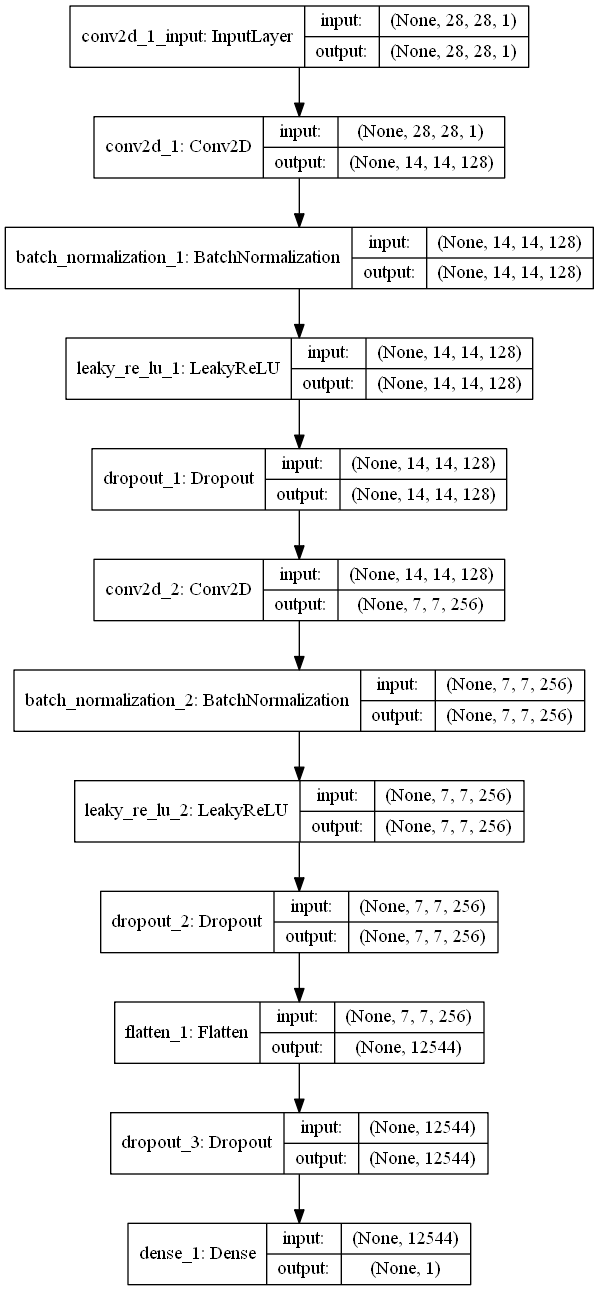

In [6]:
# Overview on discriminator structure
D.summary()
plot_model(D, to_file='DCGAN-D.png', show_shapes=True, show_layer_names=True)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
batch_normalization_3 (Batch (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 256)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 256)      

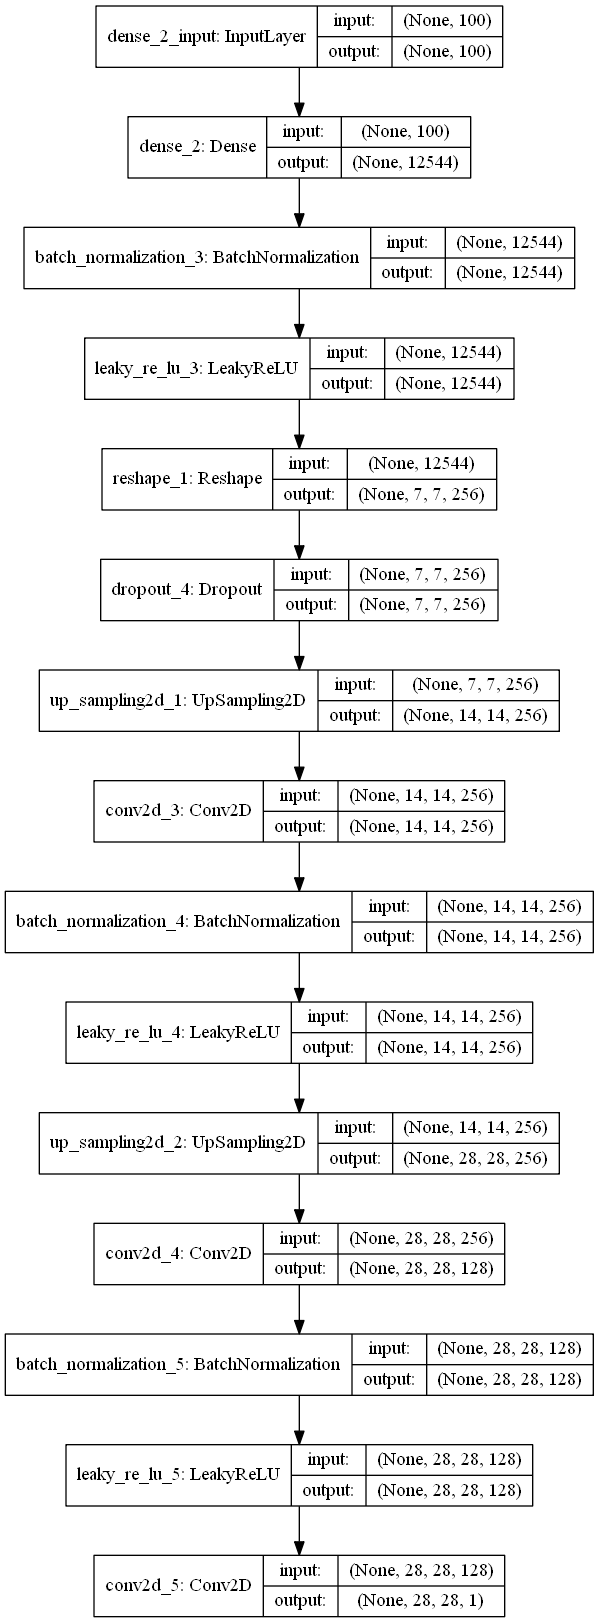

In [7]:
# Overview on generator structure
G.summary()
plot_model(G, to_file='DCGAN-G.png', show_shapes=True, show_layer_names=True)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 28, 28, 1)         2204929   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 310529    
Total params: 2,515,458
Trainable params: 2,179,073
Non-trainable params: 336,385
_________________________________________________________________


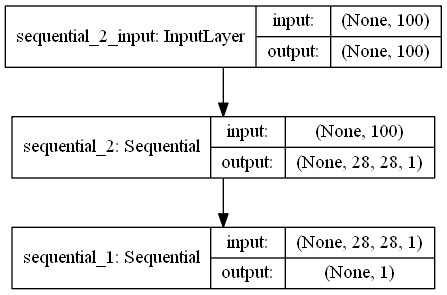

In [8]:
# Overview on DCGAN structure
GAN.summary()
plot_model(GAN, to_file='DCGAN.png', show_shapes=True, show_layer_names=True)

In [9]:
# Train DCGAN on MNIST-Digits
D_l, D_a_r, D_a_f, G_l, G_a = train(D, G, GAN, trainX, name='MNIST-D', latent_dim=latent_space)

C:\Users\Ax09\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\Ax09\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch- 0: dl=0.732 gl=1.052   da_r=0.602 da_f=0.589   ga=0.446   time=58.642
Epoch- 1: dl=0.770 gl=1.119   da_r=0.541 da_f=0.537   ga=0.309   time=53.789
Epoch- 2: dl=0.797 gl=0.975   da_r=0.492 da_f=0.496   ga=0.356   time=53.954
Epoch- 3: dl=0.779 gl=0.909   da_r=0.489 da_f=0.488   ga=0.370   time=53.953
Epoch- 4: dl=0.767 gl=0.883   da_r=0.487 da_f=0.479   ga=0.363   time=53.969
Epoch- 5: dl=0.758 gl=0.861   da_r=0.481 da_f=0.482   ga=0.367   time=53.934
Epoch- 6: dl=0.749 gl=0.849   da_r=0.484 da_f=0.484   ga=0.368   time=53.940
Epoch- 7: dl=0.746 gl=0.831   da_r=0.479 da_f=0.481   ga=0.371   time=53.930
Epoch- 8: dl=0.740 gl=0.828   da_r=0.481 da_f=0.478   ga=0.364   time=53.950
Epoch- 9: dl=0.739 gl=0.816   da_r=0.479 da_f=0.477   ga=0.367   time=53.918
Epoch-10: dl=0.736 gl=0.812   da_r=0.480 da_f=0.481   ga=0.371   time=53.944
Epoch-11: dl=0.733 gl=0.805   da_r=0.483 da_f=0.483   ga=0.373   time=53.913
Epoch-12: dl=0.733 gl=0.798   da_r=0.479 da_f=0.480   ga=0.373   time=53.939

In [10]:
# Save learning gif
save_learning_gif('Output/MNIST-D', len(D_l))

# Load learning gif
Image(url=f'Output/MNIST-D/learning.gif')

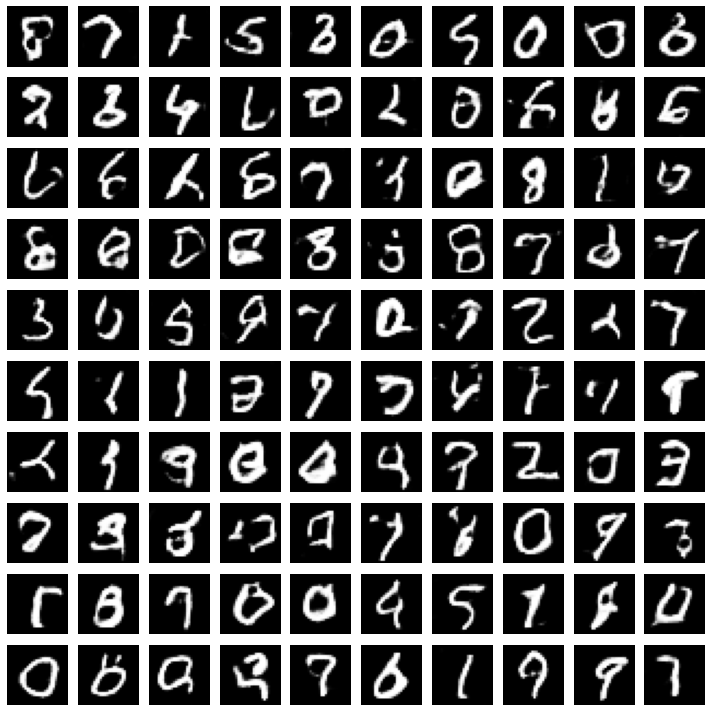

In [46]:
# Generate images from the trained generator on MNIST-D
samples = 100
gen_images(latent_space, G, samples, 'DCGAN_D_plot')


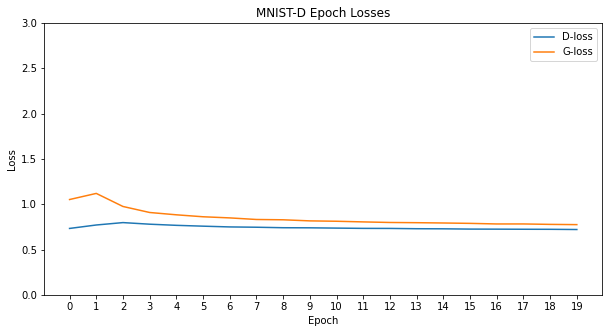

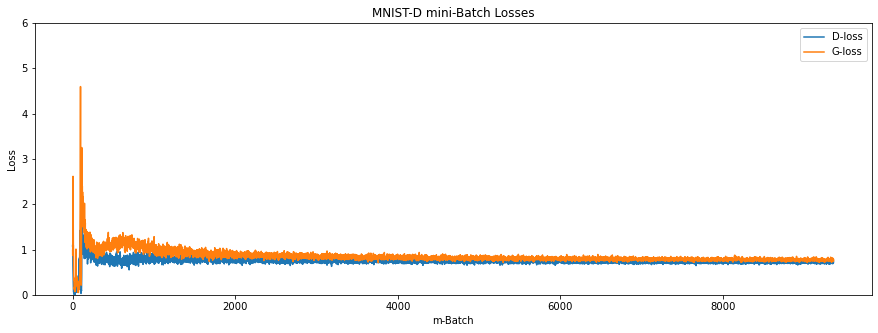

In [12]:
# Plot training loss curve
plot_loss(D_l, G_l, 'DCGAN', 'MNIST-D')

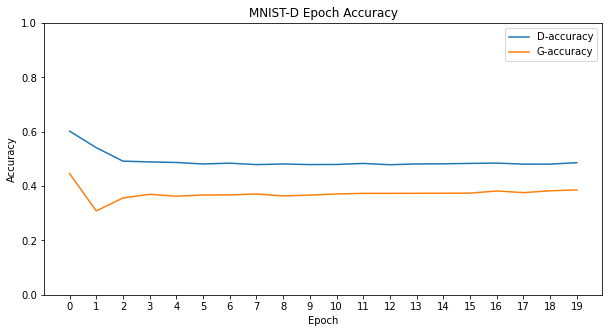

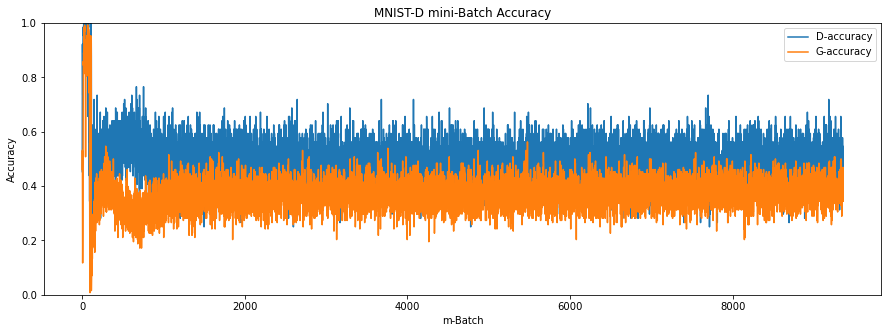

In [13]:
# Plot training accuracy curve
plot_accuracy(D_a_r, G_a, 'DCGAN', 'MNIST-D')

In [14]:
# New Instance of DCGAN to test on MNIST-Fashion

# Load dataset
fashion_mnist, fashiony = load_dataset('MNIST-F')


# Define latent space
latent_space = 100
in_shape = (fashion_mnist[0].shape[0], fashion_mnist[0].shape[1], 1)

# Build Generator and Discriminator
D_f = build_discriminator(input_shape=in_shape)
G_f = build_generator(latent_dim=latent_space)

# Create DCGAN framework
GAN_f = build_gan(D_f, G_f)

In [15]:
# Train DCGAN on Fashion-MNIST
Df_l, Df_a_r, Df_a_f, Gf_l, Gf_a = train(D_f, G_f, GAN_f, fashion_mnist, name='MNIST-F', latent_dim=latent_space)

C:\Users\Ax09\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\Ax09\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\Ax09\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch- 0: dl=0.673 gl=1.386   da_r=0.650 da_f=0.646   ga=0.350   time=57.785
Epoch- 1: dl=0.710 gl=1.588   da_r=0.604 da_f=0.613   ga=0.185   time=53.896
Epoch- 2: dl=0.782 gl=1.225   da_r=0.540 da_f=0.539   ga=0.272   time=53.869
Epoch- 3: dl=0.771 gl=1.103   da_r=0.527 da_f=0.529   ga=0.298   time=53.865
Epoch- 4: dl=0.770 gl=1.024   da_r=0.511 da_f=0.512   ga=0.308   time=53.869
Epoch- 5: dl=0.764 gl=0.971   da_r=0.505 da_f=0.507   ga=0.317   time=53.880
Epoch- 6: dl=0.755 gl=0.936   da_r=0.500 da_f=0.501   ga=0.318   time=53.900
Epoch- 7: dl=0.747 gl=0.906   da_r=0.497 da_f=0.500   ga=0.322   time=53.866
Epoch- 8: dl=0.741 gl=0.888   da_r=0.495 da_f=0.498   ga=0.329   time=53.861
Epoch- 9: dl=0.735 gl=0.871   da_r=0.505 da_f=0.504   ga=0.334   time=54.791
Epoch-10: dl=0.734 gl=0.863   da_r=0.495 da_f=0.500   ga=0.331   time=55.179
Epoch-11: dl=0.730 gl=0.856   da_r=0.501 da_f=0.506   ga=0.336   time=53.917
Epoch-12: dl=0.730 gl=0.847   da_r=0.495 da_f=0.502   ga=0.339   time=54.485

In [16]:
# Save learning gif
save_learning_gif('Output/MNIST-F', len(Df_l))

# Load learning gif
Image(url=f'Output/MNIST-F/learning.gif')

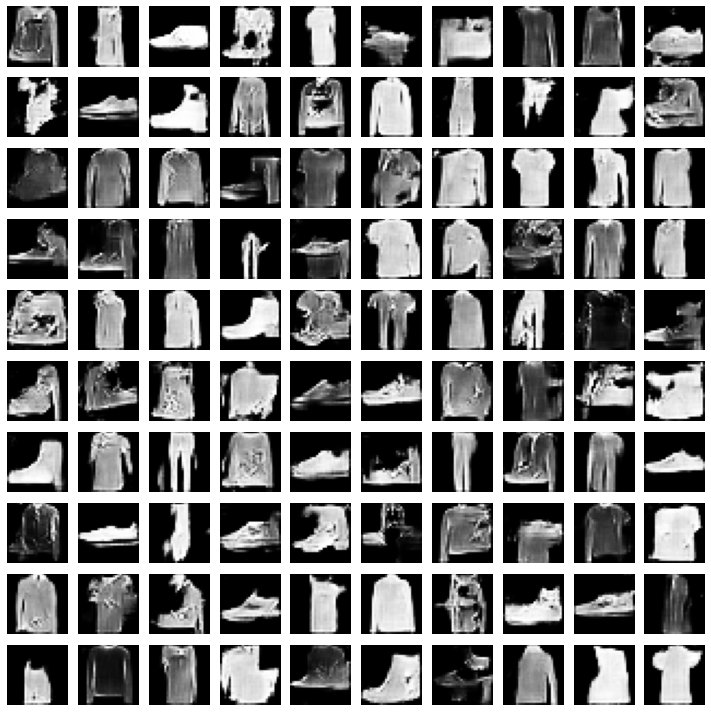

In [47]:
# Generate images from the trained generator on MNIST-F
samples = 100
gen_images(latent_space, G_f, samples, 'DCGAN_F_plot')

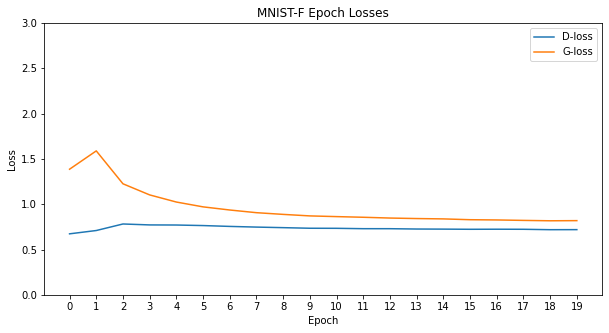

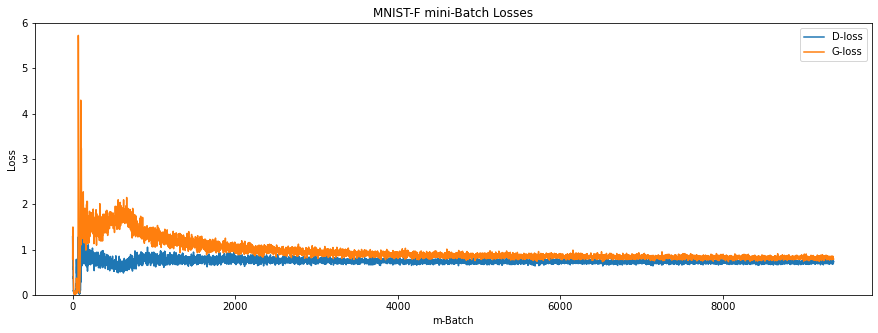

In [18]:
# Plot training loss curve
plot_loss(Df_l, Gf_l, 'DCGAN', 'MNIST-F')

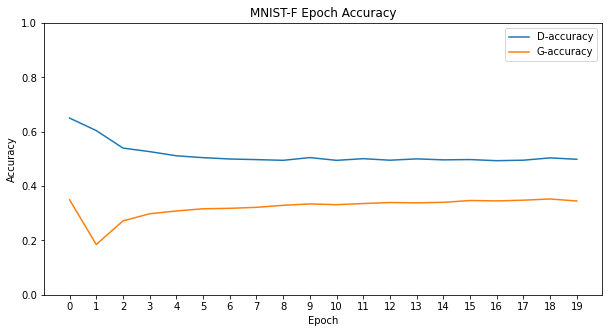

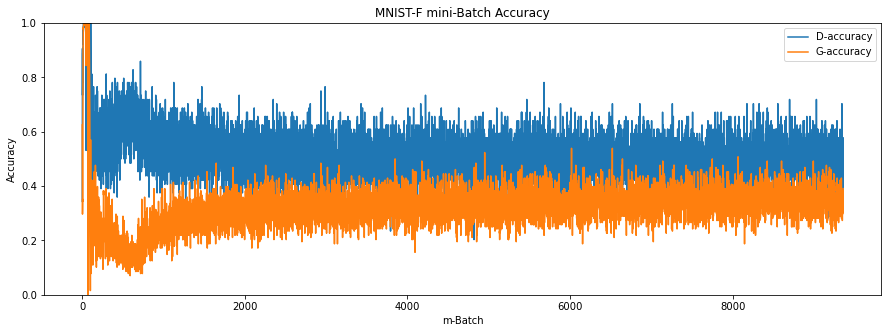

In [19]:
# Plot training accuracy curve
plot_accuracy(Df_a_r, Gf_a, 'DCGAN', 'MNIST-F')

## CDCGAN - Part2
In order to build a conditional gan we need to use also the label informatioh from the dataset and concatenate it with the training data.<br>
Following ... advices we embedded the label info in a new channel to the NN. To do this we used Keras Functional API instead of Sequential Model because this last one does not allow multiple inputs to the network.

In [20]:
# Build conditional-dcgan discriminator
def build_CD(input_shape, classes):
    
    # Define input label
    input_label = Input(shape=(1,))
    
    # One-hot-encode label on larger vector
    label_layer = Embedding(classes, 64)(input_label)
    
    # Connect one-hot-encoded layer to a fully connected one of shape of the input image and reshape
    label_layer = Dense(input_shape[0] * input_shape[1])(label_layer)
    label_layer = Reshape((input_shape[0], input_shape[1], 1))(label_layer)
    
    # Define layer for input image data
    image_layer = Input(shape=input_shape)
    
    # Concatenate image-data with label-data
    merged_layer = Concatenate()([image_layer, label_layer])
    
    # First Conv Layer
    layer = Conv2D(128, 3, strides=2, padding='same')(merged_layer)
    layer = BatchNormalization(momentum=0.9)(layer)
    layer = LeakyReLU(alpha=0.2)(layer)
    layer = Dropout(0.4)(layer)
    
    # Second Conv Layer
    layer = Conv2D(256, 3, strides=2, padding='same')(layer)
    layer = BatchNormalization(momentum=0.9)(layer)
    layer = LeakyReLU(alpha=0.2)(layer)
    layer = Dropout(0.4)(layer)
    
    # Flatten and output
    layer = Flatten()(layer)
    layer = Dropout(0.4)(layer)
    output_layer = Dense(1, activation='sigmoid')(layer)
    
    D = Model([image_layer, input_label], output_layer)
    opt = Adam(lr=0.0002, beta_1=0.5)
    D.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return D


# Build conditional-dcgan generator
def build_CG(latent_dim, classes):
    
    # Define input label
    input_label = Input(shape=(1,))
    
    # One-hot-encode on larger vector
    label_layer  = Embedding(classes, 64)(input_label)
    
    # Connect one-hot-encoded layer to a 
    label_layer = Dense(7 * 7)(label_layer)
    label_layer = Reshape((7, 7, 1))(label_layer)
    
    
    # Define noise layer 
    input_noise = Input(shape=(latent_dim,))
    noise_layer = Dense(7 * 7 * 256)(input_noise)
    noise_layer = LeakyReLU(alpha=0.2)(noise_layer)
    noise_layer = Reshape((7, 7, 256))(noise_layer)
    
    # Concatenate noise layer with label layer
    merged_layer = Concatenate()([noise_layer, label_layer])
    
    # First Upsample Layer
    layer = UpSampling2D()(merged_layer)
    layer = Conv2D(256, 3, padding='same')(layer)
    layer = BatchNormalization(momentum=0.9)(layer)
    layer = LeakyReLU(alpha=0.2)(layer)
    
    # Second Upsample Layer
    layer = UpSampling2D()(layer)
    layer = Conv2D(128, 3, padding='same')(layer)
    layer = BatchNormalization(momentum=0.9)(layer)
    layer = LeakyReLU(alpha=0.2)(layer)
    
    # Output Layer
    output_layer = Conv2D(1, 3, activation='tanh', padding='same')(layer)
    
    G = Model([input_noise, input_label], output_layer)
    return G



# Build conditional-dcgan framework
def build_CDCGAN(D, G):
    
    opt = Adam(lr=0.0002, beta_1=0.5)

    # Freeze discriminator weights during generator training
    D.trainable = False
    
    # Define generator in/out
    G_noise, G_label = G.input
    G_output = G.output
    
    print(G_output.shape, G_label.shape)
    
    # Connect G to D
    GAN_output = D([G_output, G_label])
    
    
    # Define and compile GAN model
    CDCGAN = Model([G_noise, G_label], GAN_output)
    CDCGAN.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return CDCGAN
    

In [21]:
def gen_real_c(dataset, batch_size):
    img, label = dataset
    
    random_index = np.random.randint(0, img.shape[0], size=batch_size)
    X, label = img[random_index], label[random_index]
    y = np.ones((batch_size, 1))
    return [X, label], y


def gen_fake_c(G, latent_dim, batch_size, classes):
    
    # Generate random noise + label
    z = np.random.randn(latent_dim * batch_size)
    z = z.reshape(batch_size, latent_dim)
    label = np.random.randint(0, classes, batch_size)
    
    # Predict image from noise
    X = G.predict([z, label])
    y = np.zeros((batch_size, 1))
    return [X, label], y


In [22]:
def save_plot_c(G, noise, label, epoch, name):
    # Plot generator prediction on sample_noise
    images = G.predict([noise, label])
    plt.figure(figsize=(10,10))
        
    for im in range(images.shape[0]):
        plt.subplot(4, 4, im+1)
        image = images[im, :, :, :]
        image = np.reshape(image, [28, 28])
            
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        
    plt.tight_layout()
    plt.savefig(f'Output_c/{name}/{epoch}.png')
    plt.close('all')
    
    
def save_model_c(epoch, G, D, name):
    
    # save the generator model tile file
    filename = f'Model_c/{name}/Generator/G_{epoch + 1}.h5'
    G.save(filename)
    
    # save the generator model tile file
    filename = f'Model_c/{name}/Discriminator/D_{epoch + 1}.h5'
    G.save(filename)
    
    
def train_c(D, G, GAN, dataset, name, latent_dim=100, epochs=20, batch_size=128):
    
    batch_per_epoch = int(dataset[0].shape[0] / batch_size)
    half_batch = int(batch_size / 2)
    
    sample_label = np.random.randint(0, 10, batch_size)
    sample_noise = np.random.randn(latent_dim * 16).reshape(16, latent_dim)
    
    D_loss = []
    D_acc_r = []
    D_acc_f = []
    
    G_loss = []
    G_acc = []
    
    etime = []
    

    # Loop over epochs
    for epoch in range(epochs):
        
        # Save generated samples and NN models
        save_plot_c(G, sample_noise, sample_label, epoch, name)
        save_model_c(epoch, G, D, name)
        
        start_t = time.time()
        
        eD_loss = []
        eD_acc_r = []
        eD_acc_f = []
        
        eG_loss = []
        eG_acc = []
        
        for mbatch in range(batch_per_epoch):

            # Random select half_batch real samples
            [realX, real_Label], realY = gen_real_c(dataset, half_batch)
            
            # Random generate half_batch fake samples
            [fakeX, fake_Label], fakeY = gen_fake_c(G, latent_dim, half_batch, classes=10)
            
            # Train the discriminator on the real batch, and generated batch
            D_stats_real = D.train_on_batch([realX, real_Label], realY)
            D_stats_fake = D.train_on_batch([fakeX, fake_Label], fakeY)
            
            # Generate random noise and labels to train the Generator
            label_gan = np.random.randint(0, 10, batch_size)
            Z_gan = np.random.randn(latent_dim * batch_size).reshape(batch_size, latent_dim)
            y_gan = np.ones((batch_size, 1))
            G_stats = GAN.train_on_batch([Z_gan, label_gan], y_gan)
            
            # Save batch parameters
            eD_loss.append(0.5 * (D_stats_real[0] + D_stats_fake[0]))
            eD_acc_r.append(D_stats_real[1])
            eD_acc_f.append(D_stats_fake[1])
                           
            eG_loss.append(G_stats[0])
            eG_acc.append(G_stats[1])
            
            # Log comet metrics
            #experiment.log_metrics({"loss_d":0.5 * (D_stats_real[0] + D_stats_fake[0]), "loss_g":G_stats[0], "acc_d_real":D_stats_real[1], "acc_d_fake":D_stats_fake[1], "acc_g":G_stats[1]}, step=(batch_per_epoch * epoch + mbatch))
        
        end_t = time.time()
        
        # Save all
        D_loss.append(eD_loss)
        D_acc_r.append(eD_acc_r)
        D_acc_f.append(eD_acc_f)
        G_loss.append(eG_loss)
        G_acc.append(eG_acc)
        etime.append(end_t - start_t)

        # Print epoch mean value
        print('Epoch-%2d: dl=%.3f gl=%.3f   da_r=%.3f da_f=%.3f   ga=%.3f   time=%.3f' %(epoch, np.mean(eD_loss), np.mean(eG_loss), np.mean(eD_acc_r), np.mean(eD_acc_f), np.mean(eG_acc), (etime[epoch])))

    return D_loss, D_acc_r, D_acc_f, G_loss, G_acc

In [48]:
def plot_random_sample(latent_space, cG, sample_number, classes, name):
    custom_label = []

    # Select the label that we want
    for i in range(sample_number):
        custom_label.append(np.random.randint(0, classes))

    custom_label = np.asarray(custom_label)

    # Show some generated images
    tmp_noise = np.random.randn(sample_number * latent_space).reshape(sample_number, latent_space)

    images = cG.predict([tmp_noise, custom_label])

    plt.figure(figsize=(10,10))

    for im in range(images.shape[0]):
        plt.subplot(np.sqrt(sample_number), np.sqrt(sample_number), im+1)
        image = images[im, :, :, :]
        image = np.reshape(image, [28, 28])

        plt.imshow(image, cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(f'{name}.png')
    plt.show()
    plt.close('all')


def plot_conditional_sample(latent_space, cG, sample_number, class_value, name):
    custom_label = []

    # Select the label that we want
    for i in range(sample_number):
        custom_label.append(class_value)

    custom_label = np.asarray(custom_label)

    # Show some generated images
    tmp_noise = np.random.randn(sample_number * latent_space).reshape(sample_number, latent_space)

    images = cG.predict([tmp_noise, custom_label])

    plt.figure(figsize=(10,10))

    for im in range(images.shape[0]):
        plt.subplot(np.sqrt(sample_number), np.sqrt(sample_number), im+1)
        image = images[im, :, :, :]
        image = np.reshape(image, [28, 28])

        plt.imshow(image, cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(f'{name}.png')
    plt.show()
    plt.close('all')

    
def plot_class_sample(latent_space, cG, classes, sample_number, name):
    
    # Setup image size and counter
    index = 1
    plt.figure(figsize=(10,sample_number))
    
    # Loop over the number of latent-vector
    for noise in range(sample_number):
        
        # Generate one single noise
        tmp_noise = np.random.randn(latent_space).reshape(1, latent_space)
    
        # For each noise vector generate all classes element
        for x in range(classes):
            custom_label = np.array([x, ])
            im = cG.predict([tmp_noise, custom_label])
            plt.subplot(sample_number, classes, index)
            image = np.reshape(im, [28, 28])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
            index += 1
    plt.tight_layout()
    plt.savefig(f'{name}.png')
    plt.show()
    plt.close('all')

In [24]:
# Load dataset
dataset = load_dataset('MNIST-D')

# Define latent space>
latent_space = 100
in_shape = (dataset[0].shape[1], dataset[0].shape[2], 1)
print(in_shape)
classes  = 10

# Build Generator and Discriminator
CD = build_CD(input_shape=in_shape, classes=classes)
CG = build_CG(latent_dim=latent_space, classes=classes)

# Create DCGAN framework
CGAN = build_CDCGAN(CD, CG)

(28, 28, 1)
(None, 28, 28, 1) (None, 1)


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 64)        640         input_1[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 1, 784)       50960       embedding_1[0][0]                
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
____________________________________________________________________________________________

C:\Users\Ax09\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


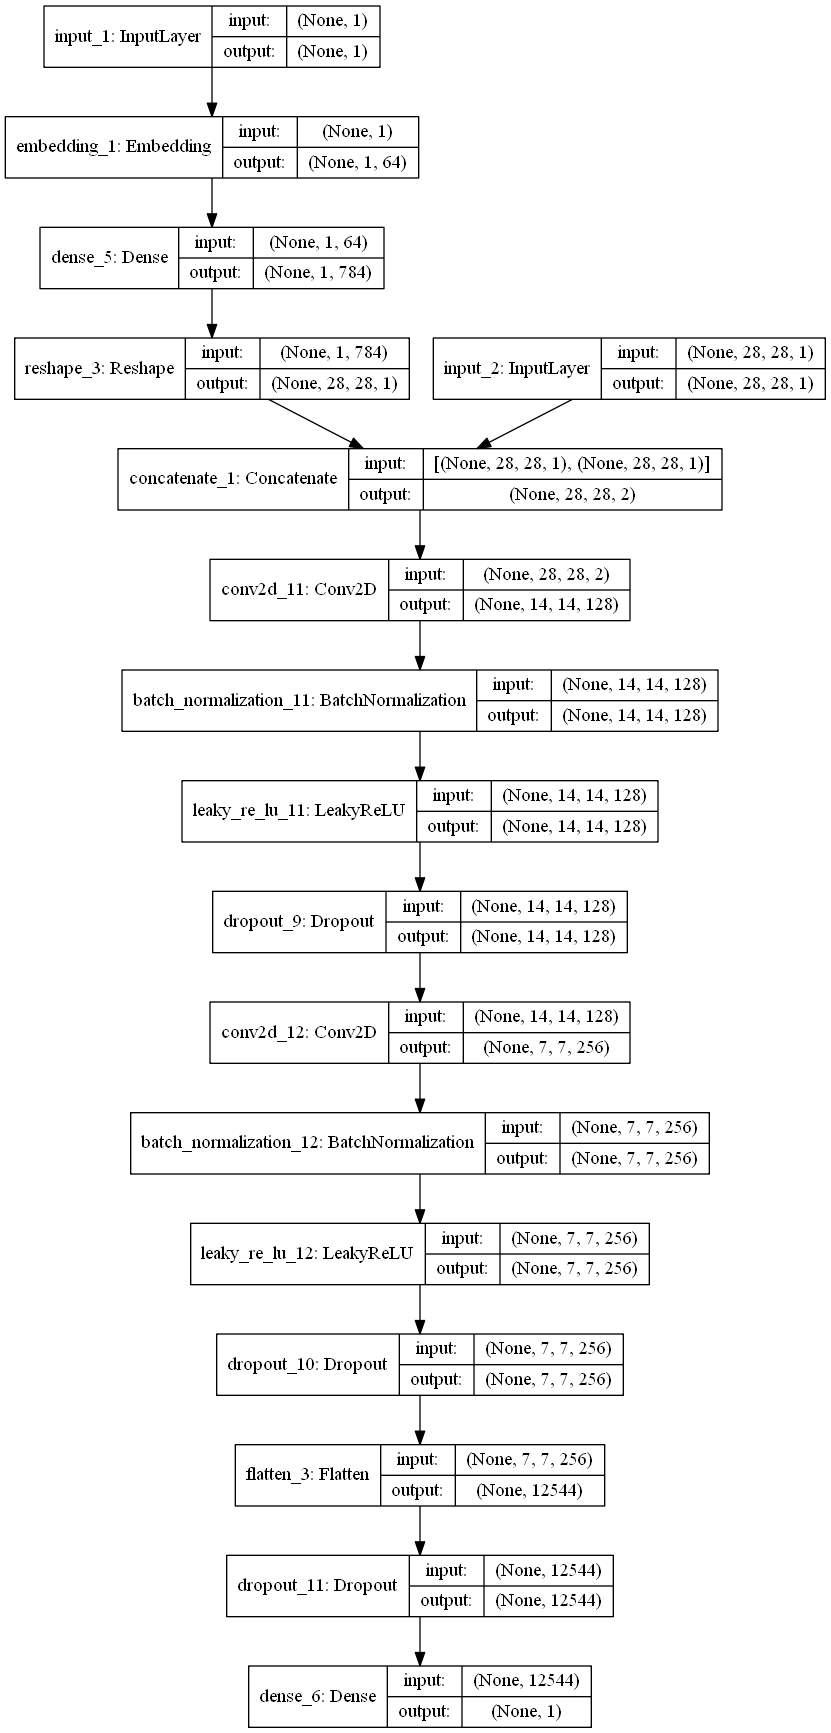

In [25]:
# Overview on DISCRIMINATOR structure
CD.summary()
plot_model(CD, to_file='CDCGAN-D.png', show_shapes=True, show_layer_names=True)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 12544)        1266944     input_4[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 64)        640         input_3[0][0]                    
____________________________________________________________________________________________

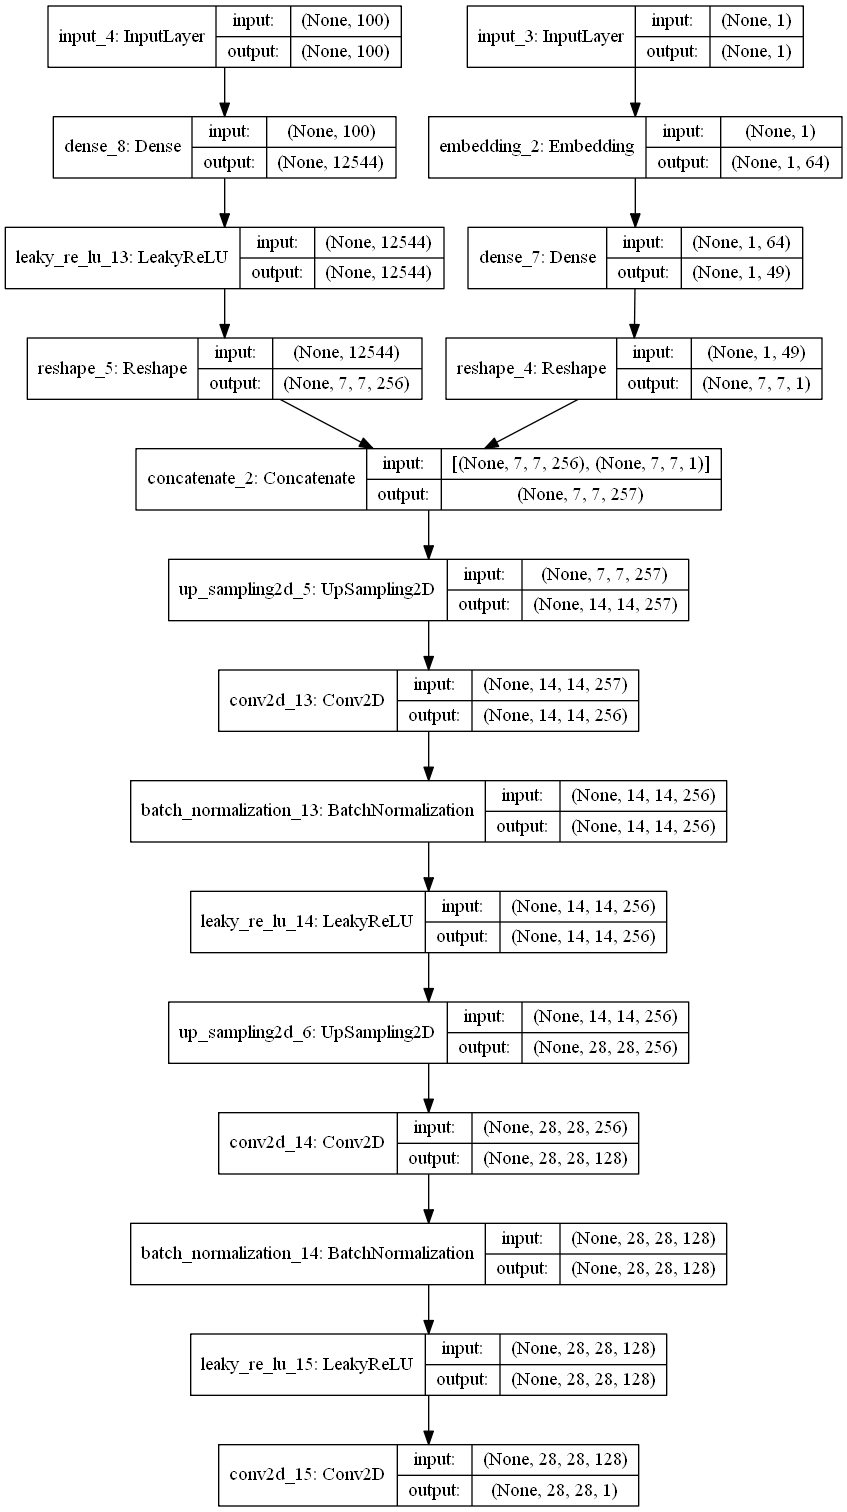

In [26]:
# Overview on generator structure
CG.summary()
plot_model(CG, to_file='CDCGAN-G.png', show_shapes=True, show_layer_names=True)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 12544)        1266944     input_4[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 64)        640         input_3[0][0]                    
____________________________________________________________________________________________

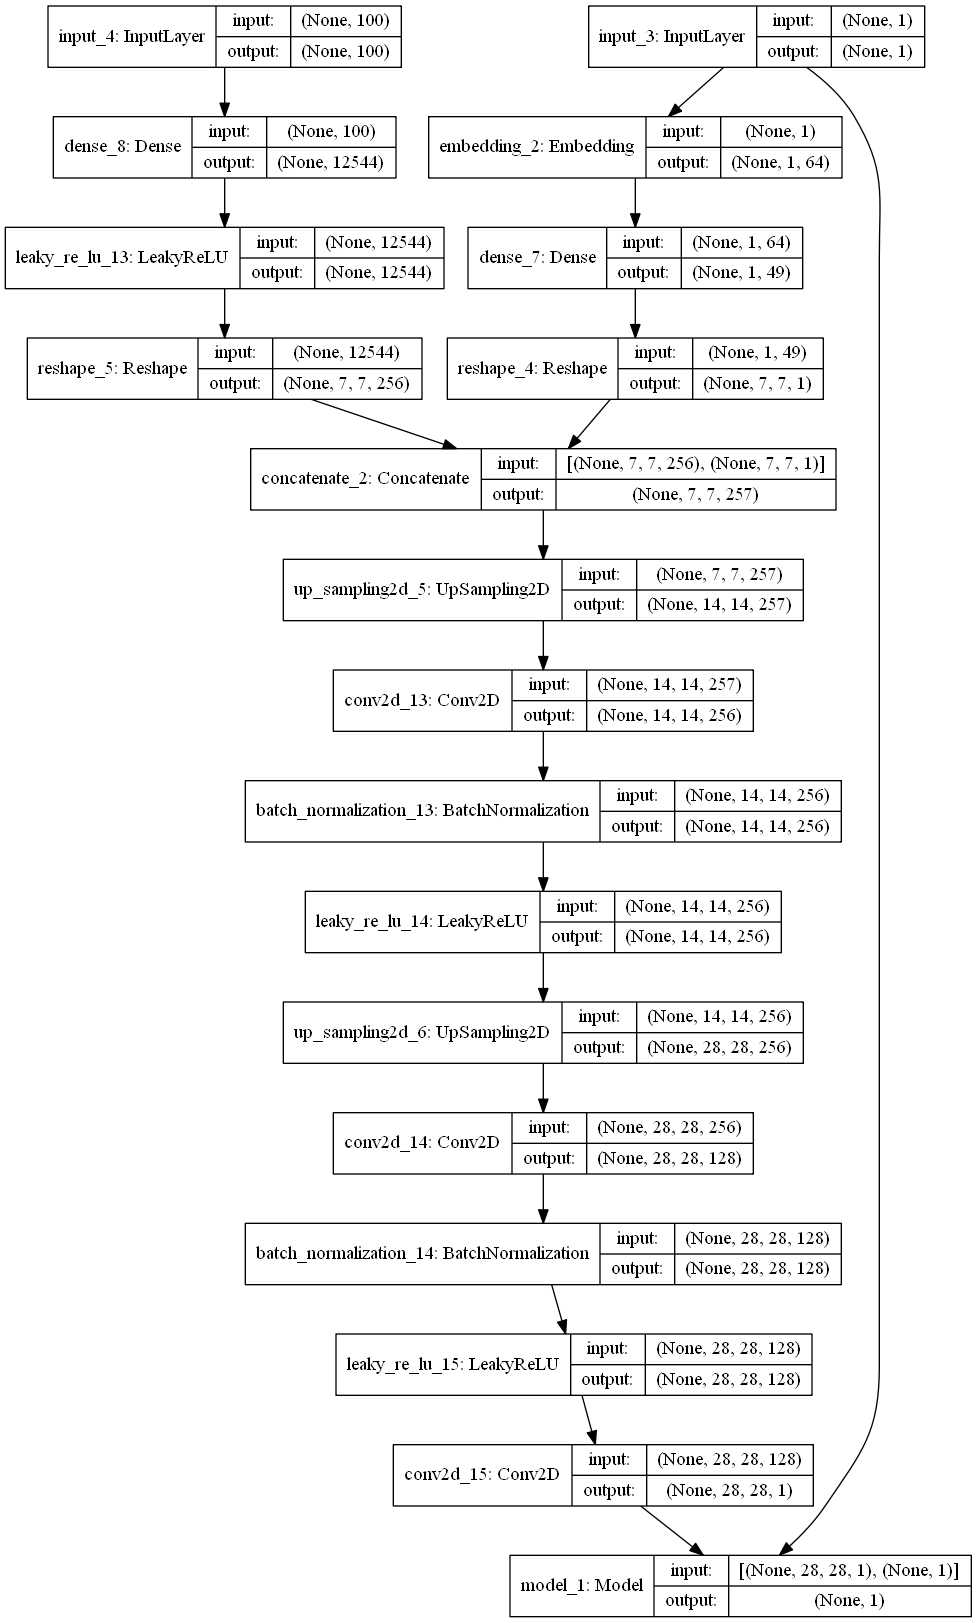

In [27]:
# Overview on generator structure
CGAN.summary()
plot_model(CGAN, to_file='CDCGAN.png', show_shapes=True, show_layer_names=True)

In [28]:
# Train CDCGAN
cD_l, cD_a_r, cD_a_f, cG_l, cG_a = train_c(CD, CG, CGAN, dataset, name='MNIST-D', latent_dim=latent_space)

C:\Users\Ax09\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Ax09\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\Ax09\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Ax09\Anaconda3\envs\tensorflow_gpuenv\li

Epoch- 0: dl=0.864 gl=1.093   da_r=0.513 da_f=0.507   ga=0.381   time=62.192
Epoch- 1: dl=0.782 gl=1.057   da_r=0.521 da_f=0.524   ga=0.330   time=57.462
Epoch- 2: dl=0.778 gl=0.974   da_r=0.501 da_f=0.506   ga=0.345   time=57.592
Epoch- 3: dl=0.755 gl=0.943   da_r=0.511 da_f=0.515   ga=0.338   time=58.231
Epoch- 4: dl=0.742 gl=0.929   da_r=0.517 da_f=0.522   ga=0.329   time=58.296
Epoch- 5: dl=0.730 gl=0.928   da_r=0.531 da_f=0.533   ga=0.328   time=58.264
Epoch- 6: dl=0.720 gl=0.919   da_r=0.540 da_f=0.542   ga=0.332   time=58.363
Epoch- 7: dl=0.722 gl=0.921   da_r=0.536 da_f=0.536   ga=0.324   time=58.330
Epoch- 8: dl=0.722 gl=0.913   da_r=0.535 da_f=0.532   ga=0.326   time=58.406
Epoch- 9: dl=0.723 gl=0.885   da_r=0.529 da_f=0.530   ga=0.338   time=57.813
Epoch-10: dl=0.721 gl=0.892   da_r=0.532 da_f=0.536   ga=0.330   time=57.976
Epoch-11: dl=0.716 gl=0.883   da_r=0.535 da_f=0.535   ga=0.328   time=58.131
Epoch-12: dl=0.710 gl=0.864   da_r=0.545 da_f=0.540   ga=0.352   time=57.418

In [29]:
# Save learning gif
save_learning_gif('Output_c/MNIST-D', len(cD_l))

# Load learning gif
Image(url=f'Output_c/MNIST-D/learning.gif')

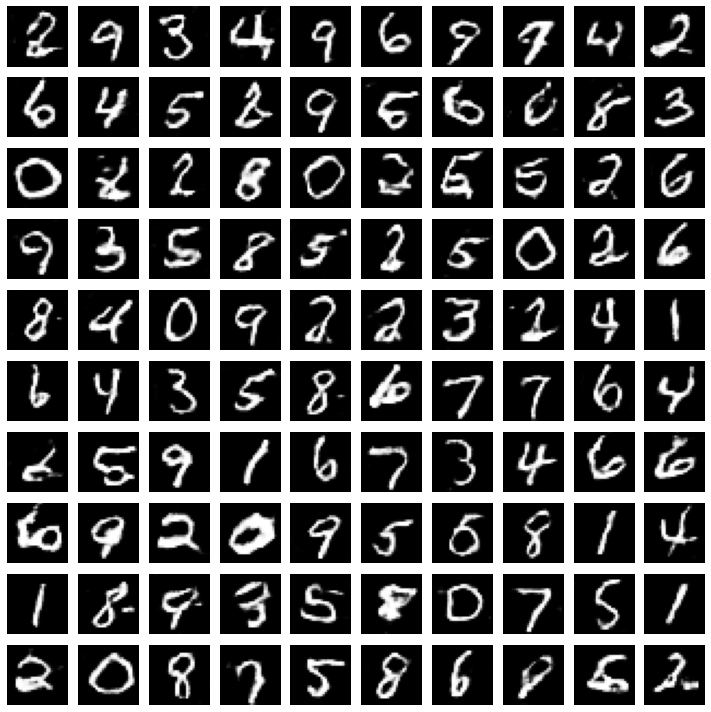

In [49]:
# Generate random samples
sample = 100
plot_random_sample(latent_space, CG, sample, classes, 'CDCGAN_D_random')

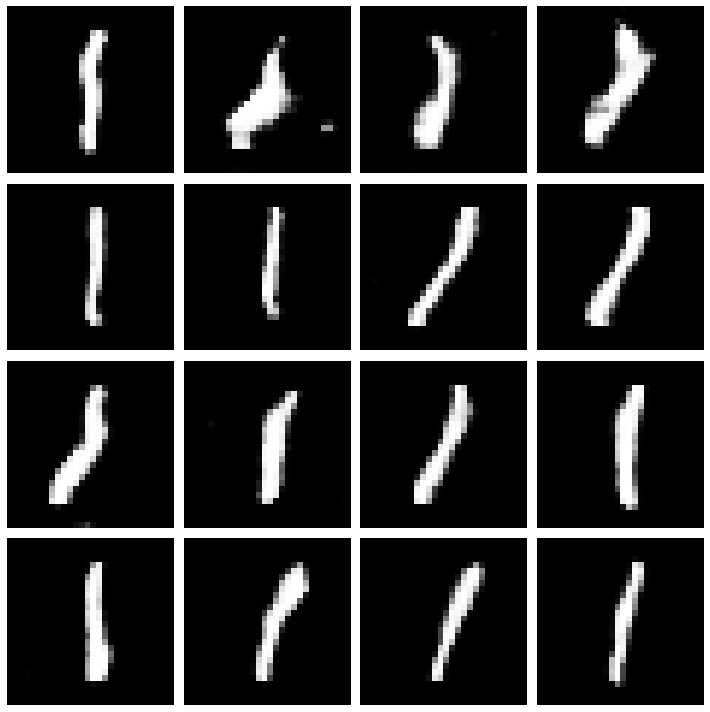

In [51]:
# Generate conditional samples with different noise vector
plot_conditional_sample(latent_space=100, cG=CG, sample_number=16, class_value=1, name='CDCGAN_D_class')

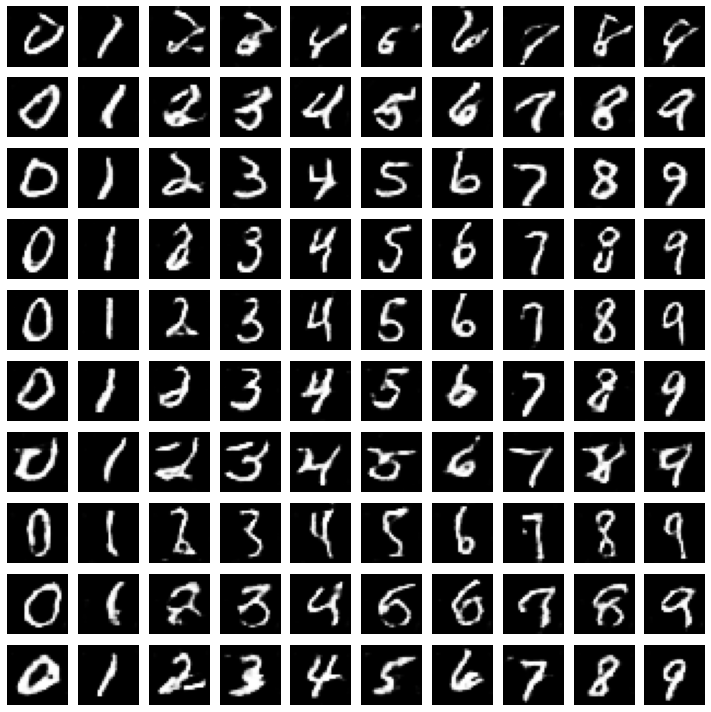

In [52]:
# Generate all all class samples from each noise vector
plot_class_sample(latent_space=100, cG=CG, classes=10, sample_number=10, name='CDCGAN_D_classcomp')

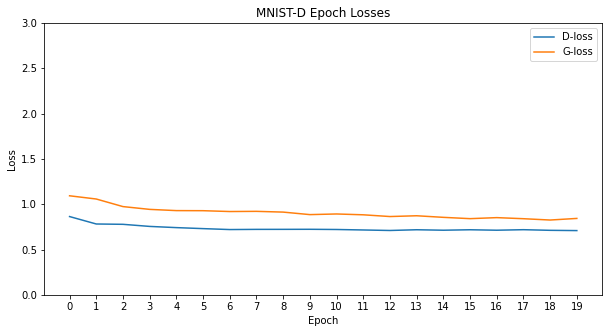

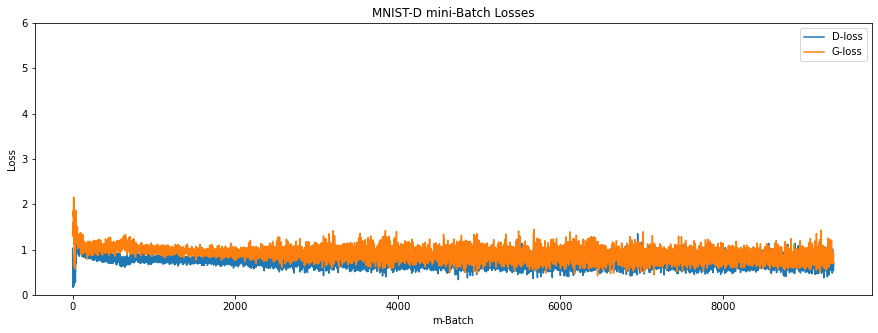

In [33]:
# Plot loss
plot_loss(cD_l, cG_l, 'CDCGAN', 'MNIST-D')

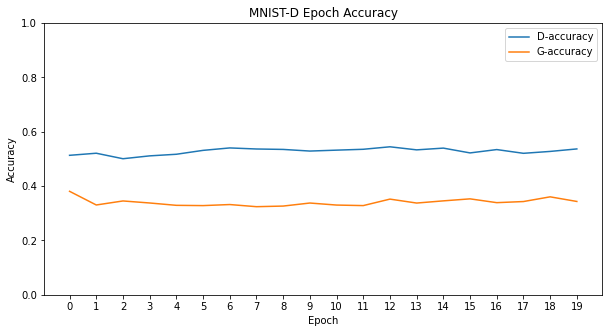

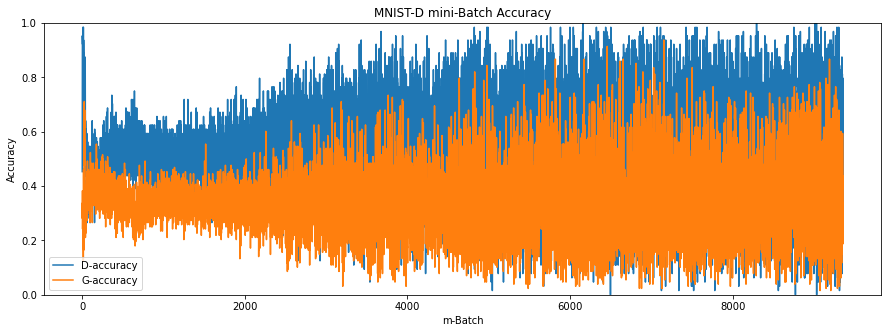

In [34]:
# Plot acuracy
plot_accuracy(cD_a_r, cG_a, 'CDCGAN', 'MNIST-D')

In [35]:
# Load MNIST-FASHION dataset
dataset_f = load_dataset('MNIST-F')

# Define latent space>
latent_space = 100
classes  = 10
in_shape = (dataset_f[0].shape[1], dataset_f[0].shape[2], 1)


# Build Generator and Discriminator
CD_f = build_CD(input_shape=in_shape, classes=classes)
CG_f = build_CG(latent_dim=latent_space, classes=classes)

# Create DCGAN framework
CGAN_f = build_CDCGAN(CD_f, CG_f)

(None, 28, 28, 1) (None, 1)


In [36]:
# Train CDCGAN ON FASHION DATASET
cDf_l, cDf_a_r, cDf_a_f, cGf_l, cGf_a = train_c(CD_f, CG_f, CGAN_f, dataset_f, name='MNIST-F', latent_dim=latent_space, epochs=20)

C:\Users\Ax09\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\Ax09\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Ax09\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\Ax09\Anaconda3\envs\tensorflow_gpuenv\lib\s

Epoch- 0: dl=0.778 gl=1.266   da_r=0.589 da_f=0.583   ga=0.336   time=59.273
Epoch- 1: dl=0.746 gl=1.241   da_r=0.574 da_f=0.587   ga=0.305   time=55.251
Epoch- 2: dl=0.748 gl=1.104   da_r=0.565 da_f=0.569   ga=0.331   time=55.566
Epoch- 3: dl=0.732 gl=1.077   da_r=0.564 da_f=0.569   ga=0.320   time=56.020
Epoch- 4: dl=0.729 gl=1.042   da_r=0.555 da_f=0.562   ga=0.318   time=55.536
Epoch- 5: dl=0.730 gl=0.994   da_r=0.550 da_f=0.554   ga=0.326   time=54.458
Epoch- 6: dl=0.735 gl=0.947   da_r=0.534 da_f=0.539   ga=0.337   time=54.431
Epoch- 7: dl=0.730 gl=0.921   da_r=0.526 da_f=0.538   ga=0.340   time=54.427
Epoch- 8: dl=0.725 gl=0.912   da_r=0.530 da_f=0.540   ga=0.339   time=54.443
Epoch- 9: dl=0.725 gl=0.894   da_r=0.527 da_f=0.530   ga=0.344   time=54.439
Epoch-10: dl=0.721 gl=0.887   da_r=0.530 da_f=0.536   ga=0.340   time=55.082
Epoch-11: dl=0.721 gl=0.879   da_r=0.526 da_f=0.530   ga=0.345   time=55.284
Epoch-12: dl=0.720 gl=0.863   da_r=0.525 da_f=0.529   ga=0.355   time=55.731

In [37]:
# Save learning gif
save_learning_gif('Output_c/MNIST-F', len(cDf_l))

# Load learning gif
Image(url=f'Output_c/MNIST-F/learning.gif')

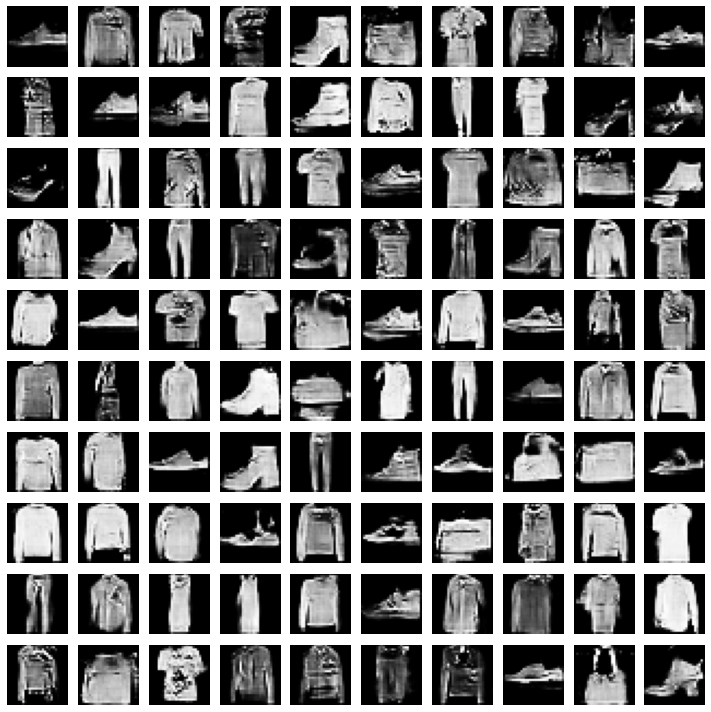

In [53]:
# Generate random samples
sample = 100
plot_random_sample(latent_space, CG_f, sample, classes, 'CDCGAN_F_random')

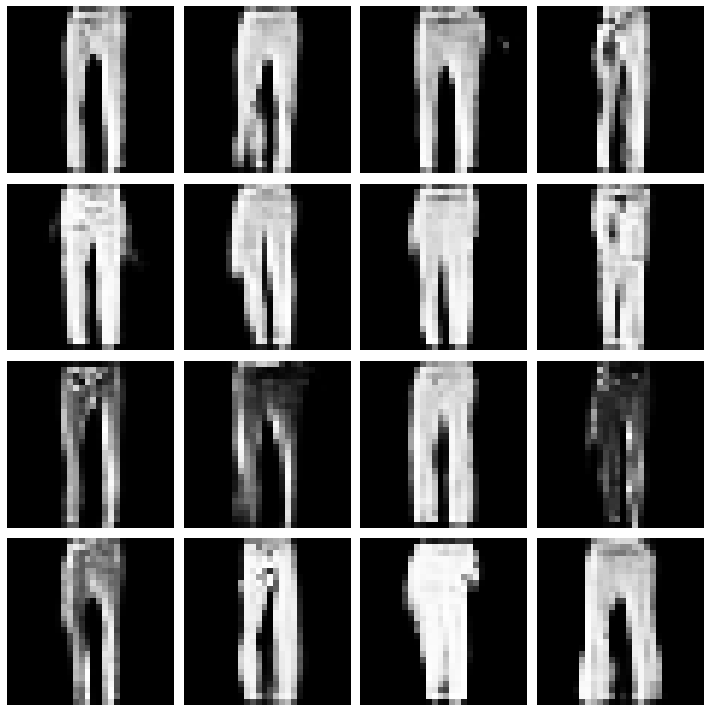

In [54]:
# Generate conditional samples with different noise vector
plot_conditional_sample(latent_space=100, cG=CG_f, sample_number=16, class_value=1, name='CDCGAN_D_class')

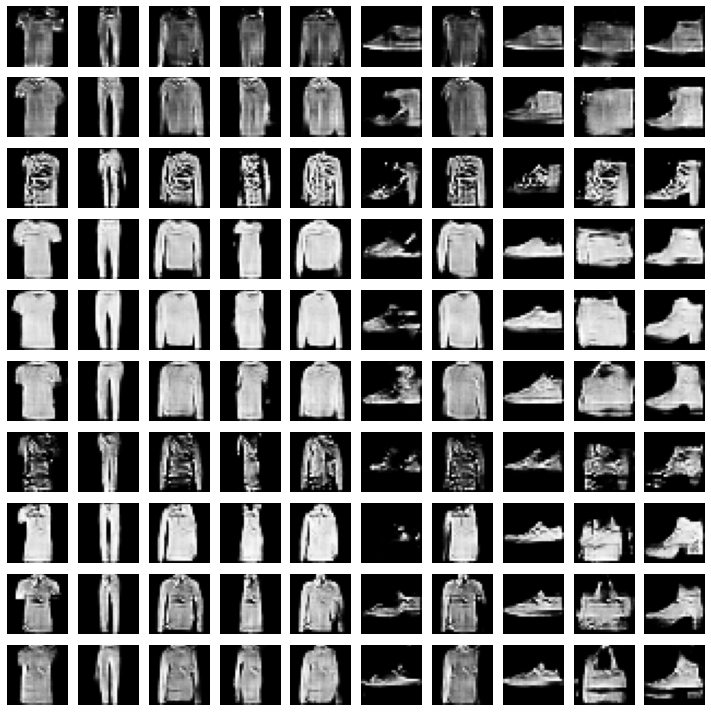

In [55]:
# Generate all all class samples from each noise vector
plot_class_sample(latent_space=100, cG=CG_f, classes=10, sample_number=10, name='CDCGAN_F_classcomp')

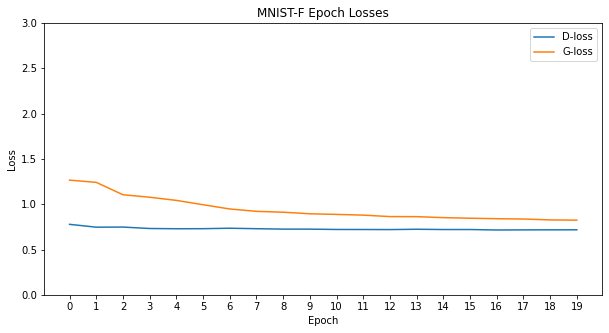

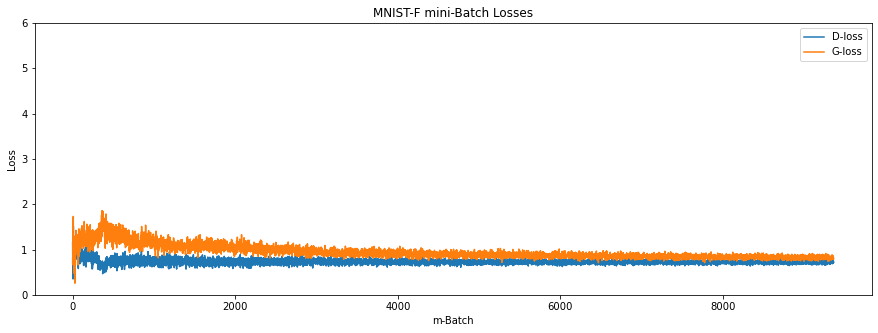

In [41]:
# Plot loss
plot_loss(cDf_l, cGf_l, 'CDCGAN', 'MNIST-F')

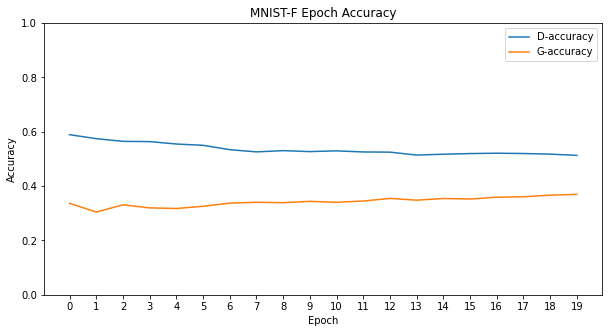

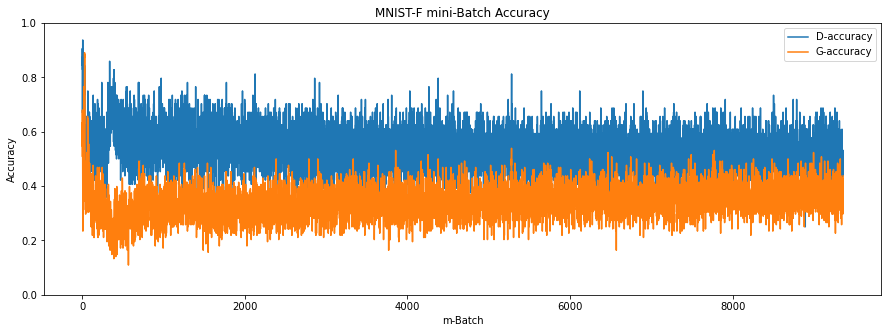

In [42]:
# Plot acuracy
plot_accuracy(cDf_a_r, cGf_a, 'CDCGAN', 'MNIST-F')

## Load Pre-Trained model to Generate Images

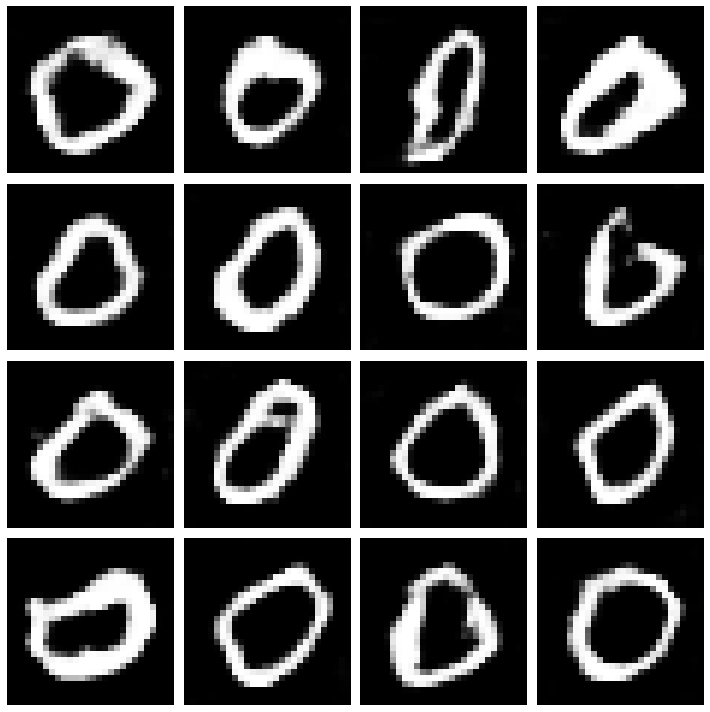

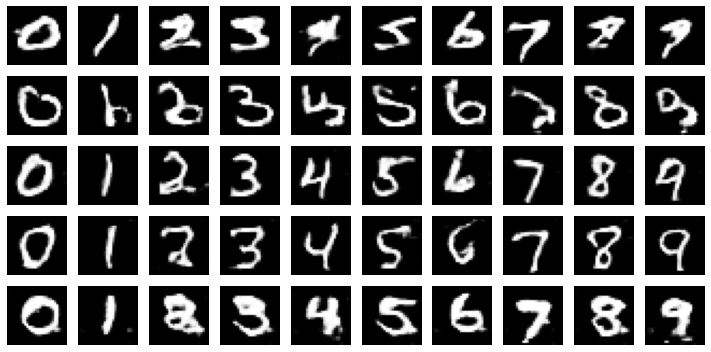

In [56]:
# Load conditional MNIST-D Generator model
cGD = load_model('Model_c/MNIST-D/Generator/G_20.h5')

plot_conditional_sample(latent_space=100, cG=cGD, sample_number=16, class_value=0, name='CDCGAN_D_load1')

plot_class_sample(latent_space=100, cG=cGD, classes=10, sample_number=5, name='CDCGAN_D_load2')

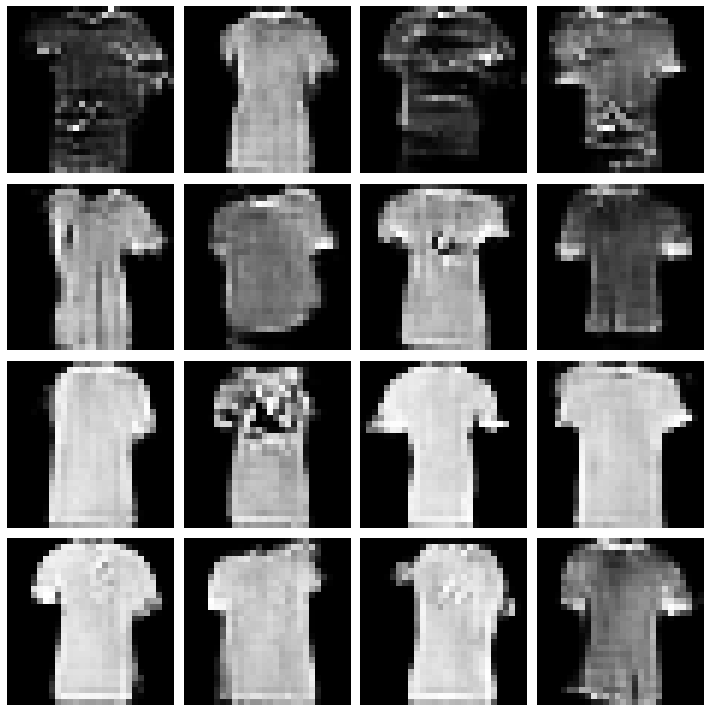

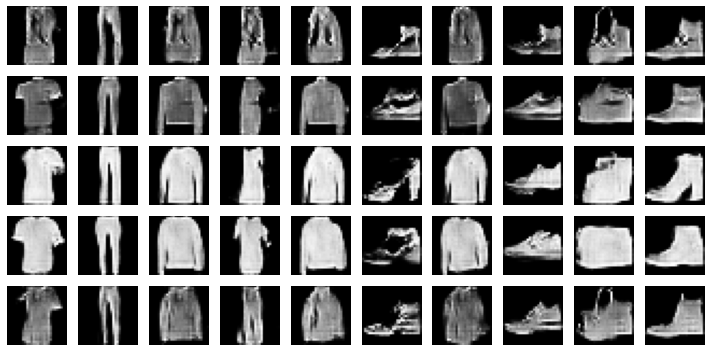

In [57]:
# Load conditional MNIST-F Generator model
cGF = load_model('Model_c/MNIST-F/Generator/G_20.h5')

plot_conditional_sample(latent_space=100, cG=cGF, sample_number=16, class_value=0, name='CDCGAN_F_load1')

plot_class_sample(latent_space=100, cG=cGF, classes=10, sample_number=5, name='CDCGAN_F_load2')